### Celem poniższej analizy była próba przewidzenia wyników pierwszej kolejki fazy grupowej Mistrzostw Świata w Katarze. Postanowiono zbudować model wielomianowej regresji logistycznej, który powstał w oparciu o dane dotyczące wyników spotkań międzynarodowych (reprezentacyjnych) od momentu opublikowania jednego z pierwszych rankingów FIFA (1993r.).  Z wykorzystaniem historycznych wyników oraz terminarza pierwszej kolejki rozgrywek, obliczono prawdopodobieństwa poszczególnych rozstrzygnięć (zwycięstwo/remis/porażka) dla 16 spotkań. Jako przewidywany rezultat postanowiono wybrać zdarzenie, któremu model przyporządkował największe prawdopopodobieństwo wystąpienia.

# Mundial 2022 - predykcja pierwszej kolejki fazy grupowej

### Import niezbędnych bibliotek

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

### Wczytanie danych

In [7]:
#Zbiór z danymi o wynikach meczów międzynarodowych od sierpnia 1993 roku, kiedy został opublikowany jeden z pierwszych rankingów FIFA.
international_matches = pd.read_csv('.../international_matches.csv')
#Zbiór zawierający informacje o spotkaniach pierwszej kolejki mundialu w Katarze
first_round = world_cup_2022 = pd.read_excel('.../first_round.xlsx')

### Przekształcenie zbioru danych

In [8]:
#Wybór potrzebnych kolumn
international_matches = international_matches.loc[:, ['date', 'home_team', 'away_team', 'home_team_fifa_rank', 
                                                      'away_team_fifa_rank', 'home_team_score', 'away_team_score', 
                                                      'tournament', 'neutral_location', 'home_team_result']]
international_matches

,date,home_team,away_team,home_team_fifa_rank,away_team_fifa_rank,home_team_score,away_team_score,tournament,neutral_location,home_team_result
0,1993-08-08,Bolivia,Uruguay,59,22,3,1,FIFA World Cup qualification,False,Win
1,1993-08-08,Brazil,Mexico,8,14,1,1,Friendly,False,Draw
2,1993-08-08,Ecuador,Venezuela,35,94,5,0,FIFA World Cup qualification,False,Win
3,1993-08-08,Guinea,Sierra Leone,65,86,1,0,Friendly,False,Win
4,1993-08-08,Paraguay,Argentina,67,5,1,3,FIFA World Cup qualification,False,Lose
...,...,...,...,...,...,...,...,...,...,...
23916,2022-06-14,Moldova,Andorra,180,153,2,1,UEFA Nations League,False,Win
23917,2022-06-14,Liechtenstein,Latvia,192,135,0,2,UEFA Nations League,False,Lose
23918,2022-06-14,Chile,Ghana,28,60,0,0,Kirin Cup,True,Lose
23919,2022-06-14,Japan,Tunisia,23,35,0,3,Kirin Cup,False,Lose


In [9]:
#Dodanie nowej kolumny fifa_rank_difference
international_matches['fifa_rank_difference'] = international_matches['home_team_fifa_rank'] - international_matches['away_team_fifa_rank']

#Dodanie nowej kolumny stakes_matches - czy mecz jest o stawkę (każdy inny niż towarzyski)
international_matches['stakes_matches'] = international_matches['tournament'] != 'Friendly'

#Na potrzeby analizy postanowiono przyjąć, iż wygrana zespołu gospodarzy będzie oznaczana cyfrą 2, 
#remis cyfrą 1, natomiast wygrana drużyny gości - 0.
international_matches.loc[international_matches.home_team_result == 'Win', 'home_team_result'] = 2
international_matches.loc[international_matches.home_team_result == 'Draw', 'home_team_result'] = 1
international_matches.loc[international_matches.home_team_result == 'Lose', 'home_team_result'] = 0
international_matches.rename(columns = {'home_team_result': 'winner'}, inplace = True)

#Ostateczny wybór zmiennych do prognozowania
international_matches = international_matches.loc[:, ['home_team', 'away_team', 'neutral_location', 'winner', 
                                                      'fifa_rank_difference', 'stakes_matches']]
international_matches

,home_team,away_team,neutral_location,winner,fifa_rank_difference,stakes_matches
0,Bolivia,Uruguay,False,2,37,True
1,Brazil,Mexico,False,1,-6,False
2,Ecuador,Venezuela,False,2,-59,True
3,Guinea,Sierra Leone,False,2,-21,False
4,Paraguay,Argentina,False,0,62,True
...,...,...,...,...,...,...
23916,Moldova,Andorra,False,2,27,True
23917,Liechtenstein,Latvia,False,0,57,True
23918,Chile,Ghana,True,0,-32,True
23919,Japan,Tunisia,False,0,-12,True


### Opis zbioru danych

In [10]:
# W modelu zawarto następujące zmienne:
#     a) zmienna objaśniana 'winner', której wartości będą prognozowane
#     b) zmienne objaśniające:
#         - home_team - nazwa drużyny gospodarzy
#         - away_team - nazwa drużyny gości
#         - neutral_location - zawiera informację czy dany mecz odbywa/odbywał się na neutralnym terenie
#         - fifa_rank_difference - różnica pozycji między drużynami na dzień rozgrywania spotkania
#         - stakes_matches - czy dany mecz był rywalizacją o stawkę (mecz o stawkę = każdy inny niż towarzyski)

# Ze względu na fakt, iż zmienna objaśniana posiada 3 wartości (wygrana gospodarzy, remis, wygrana gości), do prognozowania 
# spotkań pierwszej rundy postanowiono wykorzystać wielomianową regresję logistyczną.

### Budowa i uczenie modelu

In [11]:
#Przygotowanie danych do przeprowadzenia regresji - stworzenie kolumn, które przechowują w postaci binarnej informacje
#o gospodarzu i gościu każdego ze spotkań.
international_matches_final = pd.get_dummies(international_matches, prefix = ['home_team', 'away_team'], 
                                              columns = ['home_team', 'away_team'])
international_matches_final

,neutral_location,winner,fifa_rank_difference,stakes_matches,home_team_Afghanistan,home_team_Albania,home_team_Algeria,home_team_American Samoa,home_team_Andorra,home_team_Angola,...,away_team_United Arab Emirates,away_team_Uruguay,away_team_Uzbekistan,away_team_Vanuatu,away_team_Venezuela,away_team_Vietnam,away_team_Wales,away_team_Yemen,away_team_Zambia,away_team_Zimbabwe
0,False,2,37,True,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,False,1,-6,False,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,False,2,-59,True,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,False,2,-21,False,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,False,0,62,True,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23916,False,2,27,True,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23917,False,0,57,True,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23918,True,0,-32,True,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23919,False,0,-12,True,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
#Podział na dwa zbiory - w pierwszym zmienne, których zadaniem będzie prognoza
#zmiennej objaśniającej, która znajdzie się w drugim z nich.
X = international_matches_final.drop(['winner'], axis = 1)
y = international_matches_final['winner']
y = y.astype('int')

In [13]:
#Podział na zbiory treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [14]:
#Wielomianowa regresja logistyczna
mul_lr = LogisticRegression(multi_class='multinomial', solver='newton-cg')

In [15]:
mul_lr.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial', solver='newton-cg')

In [16]:
#Obliczenie skuteczności prognoz na zbiorach treningowym i testowym
score_train = mul_lr.score(X_train, y_train)
score_test = mul_lr.score(X_test, y_test)

In [17]:
score_train

0.6102564102564103

In [18]:
score_test

0.5927102491222204

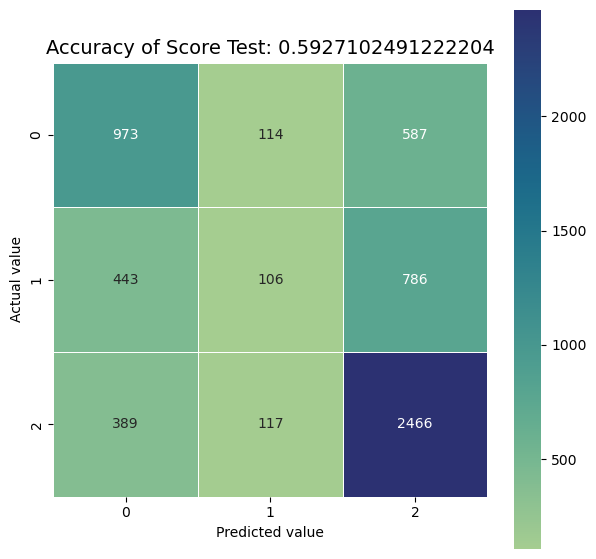

In [19]:
#Nieco więcej niż 59% skuteczności na zbiorze testowym uznano za wynik zadowalający jak na liczbę wykorzystanych w modelu zmiennych.

#Skonstruowanie macierzy pomyłek i jej wizualizacja
preds = mul_lr.predict(X_test)
confusion_matrix = metrics.confusion_matrix(y_test, preds)

plt.figure(figsize=(7,7))
sns.heatmap(confusion_matrix, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'crest');
plt.ylabel('Actual value');
plt.xlabel('Predicted value');
all_sample_title = 'Accuracy of Score Test: {0}'.format(score_test)
plt.title(all_sample_title, size = 14);

## Prognozowanie wyników pierwszej rundy fazy grupowej

In [20]:
#Widok zbioru danych
first_round

,home_team,away_team,home_team_fifa_rank,away_team_fifa_rank,neutral_location,stakes_matches,group
0,Qatar,Ecuador,50,44,False,True,A
1,Ecuador,Qatar,44,50,False,True,A
2,Senegal,Netherlands,18,8,True,True,A
3,Netherlands,Senegal,8,18,True,True,A
4,England,IR Iran,5,20,True,True,B
5,IR Iran,England,20,5,True,True,B
6,USA,Wales,16,19,True,True,B
7,Wales,USA,19,16,True,True,B
8,Argentina,Saudi Arabia,3,51,True,True,C
9,Saudi Arabia,Argentina,51,3,True,True,C


In [21]:
#Biorąc pod uwagę fakt, że mundial odbywa się w jednym kraju, zdecydowana większość spotkań (poza meczami gospodarzy) ma miejsce 
#na neutralnym terenie. Na potrzeby analizy postanowiono uporządkować zbiór w taki sposób, aby drużyna, która znajduje się aktualnie 
# wyżej w rankingu FIFA, została umieszczona w kolumnie "home_team" (poza spotkaniami Kataru, który zawsze jest gospodarzem meczu).
first_round_final = first_round.copy()

for i in range(32):
    if first_round_final.away_team[i] == 'Qatar':
        first_round_final.home_team[i] = first_round.away_team[i]
        first_round_final.away_team[i] = first_round.home_team[i]
        first_round_final.home_team_fifa_rank[i] = first_round.away_team_fifa_rank[i]
        first_round_final.away_team_fifa_rank[i] = first_round.home_team_fifa_rank[i]
    elif first_round_final.home_team_fifa_rank[i] > first_round_final.away_team_fifa_rank[i] and first_round_final.home_team[i] != 'Qatar' and first_round_final.away_team[i] != 'Qatar':
        first_round_final.home_team[i] = first_round.away_team[i]
        first_round_final.away_team[i] = first_round.home_team[i]
        first_round_final.home_team_fifa_rank[i] = first_round.away_team_fifa_rank[i]
        first_round_final.away_team_fifa_rank[i] = first_round.home_team_fifa_rank[i]
    else:
        None

first_round_final = first_round_final.drop_duplicates()
first_round_final = first_round_final.reset_index()
first_round_final['fifa_rank_difference'] = first_round_final['home_team_fifa_rank'] - first_round_final['away_team_fifa_rank']
first_round_final = first_round_final.loc[:, ['home_team', 'away_team', 'neutral_location', 
                                              'fifa_rank_difference', 'stakes_matches', 'group']]
first_round_final

C:\Users\krzys\AppData\Local\Temp\ipykernel_11916\960820815.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_round_final.home_team[i] = first_round.away_team[i]
C:\Users\krzys\AppData\Local\Temp\ipykernel_11916\960820815.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_round_final.away_team[i] = first_round.home_team[i]
C:\Users\krzys\AppData\Local\Temp\ipykernel_11916\960820815.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

,home_team,away_team,neutral_location,fifa_rank_difference,stakes_matches,group
0,Qatar,Ecuador,False,6,True,A
1,Netherlands,Senegal,True,-10,True,A
2,England,IR Iran,True,-15,True,B
3,USA,Wales,True,-3,True,B
4,Argentina,Saudi Arabia,True,-48,True,C
5,Mexico,Poland,True,-13,True,C
6,France,Australia,True,-34,True,D
7,Denmark,Tunisia,True,-20,True,D
8,Spain,Costa Rica,True,-24,True,E
9,Germany,Japan,True,-13,True,E


In [22]:
#Przekształcenie zmiennych z nazwami drużyn na binarne, podobnie jak przy uczeniu modelu
first_round_final1 = first_round_final.drop('group', axis = 1)
first_round_prediction = pd.get_dummies(first_round_final1, prefix = ['home_team', 'away_team'], columns = ['home_team', 'away_team'])

#Dodanie zmiennych binarnych zawierających drużyny, które nie biorą udziału w mundialu, ale "brały udział" w uczeniu modelu
missing_dummies = set(international_matches_final.columns) - set(first_round_prediction.columns)

for j in missing_dummies:
    first_round_prediction[j] = 0
first_round_prediction = first_round_prediction[international_matches_final.columns]

first_round_prediction = first_round_prediction.drop('winner', axis = 1)
first_round_prediction

C:\Users\krzys\AppData\Local\Temp\ipykernel_11916\2080279089.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  first_round_prediction[j] = 0
C:\Users\krzys\AppData\Local\Temp\ipykernel_11916\2080279089.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  first_round_prediction[j] = 0
C:\Users\krzys\AppData\Local\Temp\ipykernel_11916\2080279089.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at on

,neutral_location,fifa_rank_difference,stakes_matches,home_team_Afghanistan,home_team_Albania,home_team_Algeria,home_team_American Samoa,home_team_Andorra,home_team_Angola,home_team_Anguilla,...,away_team_United Arab Emirates,away_team_Uruguay,away_team_Uzbekistan,away_team_Vanuatu,away_team_Venezuela,away_team_Vietnam,away_team_Wales,away_team_Yemen,away_team_Zambia,away_team_Zimbabwe
0,False,6,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,True,-10,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,True,-15,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,True,-3,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,True,-48,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,True,-13,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,True,-34,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,True,-20,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,True,-24,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,True,-13,True,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
#Prognoza z wykorzystaniem zbudowanego modelu i przygotowanego zbioru
prediction = mul_lr.predict(first_round_prediction)
prediction

array([0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

# Rezultaty

In [24]:
for i in range(16):
    print('Group {}: '.format(first_round_final.group[i]) + first_round_final.home_team[i] + ' vs ' + first_round_final.away_team[i])
    print('Probability of ' + first_round_final.home_team[i] + ' win: ', round(mul_lr.predict_proba(first_round_prediction)[i][2], 3))
    print('Probability of draw: ', round(mul_lr.predict_proba(first_round_prediction)[i][1], 3))
    print('Probability of ' + first_round_final.away_team[i] + ' win: ', round(mul_lr.predict_proba(first_round_prediction)[i][0], 3))
    if prediction[i] == 2:
        print('Predicted result: ' + first_round_final.home_team[i])
    elif prediction[i] == 1:
        print('Predicted result: Draw')
    else:
        print('Predicted result: ' + first_round_final.away_team[i])
    print('')

Group A: Qatar vs Ecuador
Probability of Qatar win:  0.312
Probability of draw:  0.317
Probability of Ecuador win:  0.371
Predicted result: Ecuador

Group A: Netherlands vs Senegal
Probability of Netherlands win:  0.58
Probability of draw:  0.229
Probability of Senegal win:  0.191
Predicted result: Netherlands

Group B: England vs IR Iran
Probability of England win:  0.569
Probability of draw:  0.192
Probability of IR Iran win:  0.239
Predicted result: England

Group B: USA vs Wales
Probability of USA win:  0.38
Probability of draw:  0.165
Probability of Wales win:  0.455
Predicted result: Wales

Group C: Argentina vs Saudi Arabia
Probability of Argentina win:  0.794
Probability of draw:  0.143
Probability of Saudi Arabia win:  0.063
Predicted result: Argentina

Group C: Mexico vs Poland
Probability of Mexico win:  0.453
Probability of draw:  0.267
Probability of Poland win:  0.28
Predicted result: Mexico

Group D: France vs Australia
Probability of France win:  0.626
Probability of dr